In [8]:
from open_clip import create_model_from_pretrained, get_tokenizer

model, preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
model.cuda()
tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

In [9]:
target_layer = model.visual.trunk.blocks[11]

In [28]:
from mimic_dataset import MIMIC_CXR_Dataset
from torch.utils.data import DataLoader

dataset = MIMIC_CXR_Dataset()
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [29]:
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)  # shape: [1, 197, 768]

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])  # same shape

# Hook into last block of transformer
target_layer = model.visual.trunk.blocks[11]
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)


In [30]:
image, image_path, report = next(iter(dataloader))
image_tensor = image.cuda()
text_tokens = tokenizer([report[0]]).cuda()

In [31]:
image_tensor.requires_grad_()
model.eval()
image_features = model.encode_image(image_tensor)
text_features = model.encode_text(text_tokens)
score = (image_features @ text_features.T)[0][0]
score.backward()

In [32]:
# Grab values
grads = gradients[0]         # shape: [1, 197, 768]
acts = activations[0]        # shape: [1, 197, 768]

# Global average pooling over tokens
weights = grads.mean(dim=1)  # shape: [1, 768]

# Weighted sum of activations
cam = (weights.unsqueeze(1) * acts).sum(dim=-1)  # shape: [1, 197]

# Remove CLS token and reshape
cam = cam[0, 1:].reshape(14, 14).cpu().detach().numpy()  # [196] -> [14, 14]

# Normalize
cam = (cam - cam.min()) / (cam.max() - cam.min())


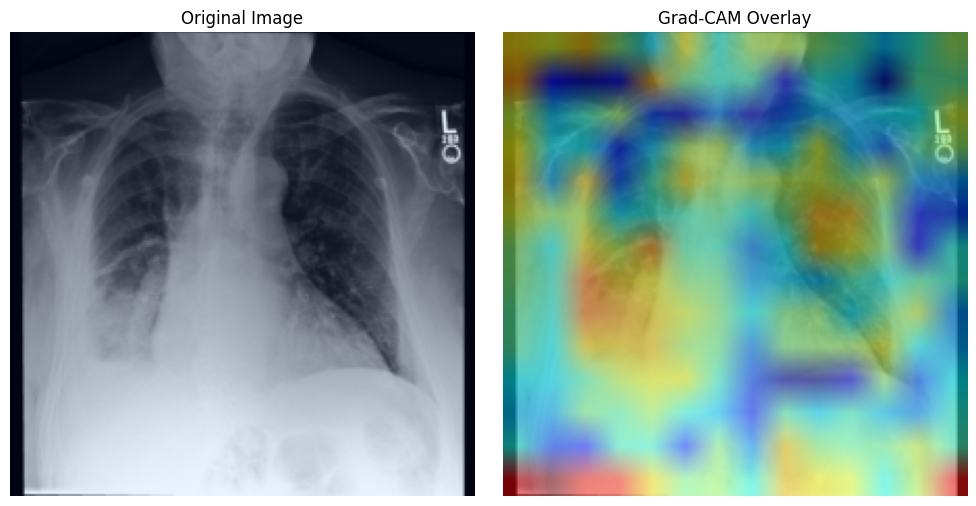

In [33]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Prepare original image
img_np = image_tensor[0].detach().permute(1, 2, 0).cpu().numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

# Prepare heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
heatmap = cv2.resize(heatmap, (224, 224))

# Blend heatmap with original image
overlay = 0.5 * img_np + 0.5 * heatmap / 255.0
overlay = np.clip(overlay, 0, 1)  # Ensure valid pixel range

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img_np)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(overlay)
axs[1].set_title("Grad-CAM Overlay")
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [54]:
print(report[0])

                                 FINAL REPORT
 EXAMINATION:  CHEST (PORTABLE AP)
 
 INDICATION:  ___ year old woman with PTX s/p pigtail placement - eval for
 interval change  // interval change
 
 COMPARISON:   Chest x-ray from ___ 16:44
 
 FINDINGS: 
 
 A left sided pigtail catheter is in place. The previously seen basilar
 pneumothorax is not clearly identified on this film. No obvious pneumothorax
 is detected at this time. There is a small effusion at the left lung base with
 underlying collapse and or consolidation which has progressed compared with
 the prior film.
 
 Again seen is some focal density overlying the left lung apex, not fully
 characterized. Also again seen are sutures in the left upper zone.
 
 There is minimal atelectasis at the right base, which is new compared with the
 prior film. No gross right effusion.
 
 There is probable background hyperinflation/ COPD. The heart is not enlarged.
 No CHF There is an apparent hiatal hernia.
 
 IMPRESSION: 
 
 1)  No defini